# Offline RAG Evaluation

We'd like to evaluate how well our RAG answers questions on the Kenyan Constitution. We already have synthetic evaluation data generated by an LLM. For each article of the constitution, we generated questions for which that article is the answer. To evaluation the rag, we'll use two measures:

- The cosine similarity between the expected answer (relevant article) and the RAG response
- LLM as judge: We'll provide the LLM a question, the expected answer and the generated response, and ask it whether the generated response is relevant.

## Data preparation

In [1]:
pip install -q pandas tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

Load previously generated synthetic evaluation data:

In [3]:
![ -f rag_evaluation_data.csv ] || wget https://raw.githubusercontent.com/programmer-ke/katiba-chat/refs/heads/master/notebooks/rag_evaluation_data.csv

In [4]:
df_eval_data = pd.read_csv("rag_evaluation_data.csv")
df_eval_data

,question,article_number
0,Who holds all sovereign power in Kenya accordi...,1
1,How can the people of Kenya exercise their sov...,1
2,To which state organs is sovereign power deleg...,1
3,At which levels is the sovereign power of the ...,1
4,What makes this Constitution the ultimate auth...,2
...,...,...
1312,What was the previous constitution that was in...,264
1313,When did the previous constitution cease to be...,264
1314,What happened to the previous constitution on ...,264
1315,What is the Sixth Schedule in relation to the ...,264


It has two columns, a question and the associated article number that indicates the expected response. Each article has a number of associated questions.

Next, we load the articles:

In [5]:
![ ! -f constitution.json ] && wget https://raw.githubusercontent.com/programmer-ke/constitution_kenya/refs/heads/master/json/ConstitutionKenya2010.json -O constitution.json

In [6]:
import json

with open('constitution.json', 'rt') as f:
    articles = json.load(f)

documents = []
for article in articles:
    
    article_text = "".join(article['lines'])
    article_title = f"Article {article['number']}: {article['title']}"
    chapter_number, chapter_title = article['chapter']
    chapter_text = f"Chapter {chapter_number}: {chapter_title}"
    part_text = ""
    
    if article['part']:
        part_num, part_title = article['part']
        part_text = f'Part {part_num}: {part_title}'
        
    documents.append({
        "title": article_title,
        "clauses": article_text,
        "chapter": chapter_text,
        "part": part_text,
        "number": article['number']
    })

In [7]:
documents[:2]

[{'title': 'Article 1: Sovereignty of the people.',
  'clauses': '(1)  All sovereign power belongs to the people of Kenya and shall be exercised\nonly in accordance with this Constitution.\n(2)  The people may exercise their sovereign power either directly or through their\ndemocratically elected representatives.\n(3)  Sovereign power under this Constitution is delegated to the following State\norgans, which shall perform their functions in accordance with this Constitution—\n(a) Parliament and the legislative assemblies in the county governments;\n(b) the national executive and the executive structures in the county\ngovernments; and\n(c) the Judiciary and independent tribunals.\n(4)  The sovereign power of the people is exercised at—\n(a) the national level; and\n(b) the county level.\n',
  'chapter': 'Chapter 1: SOVEREIGNTY OF THE PEOPLE AND SUPREMACY OF THIS CONSTITUTION',
  'part': '',
  'number': 1},
 {'title': 'Article 2: Supremacy of this Constitution.',
  'clauses': '(1)  This

In [8]:
evaluation_data = df_eval_data.to_dict(orient='records')
evaluation_data[:3]

[{'question': 'Who holds all sovereign power in Kenya according to this Constitution?',
  'article_number': 1},
 {'question': 'How can the people of Kenya exercise their sovereign power?',
  'article_number': 1},
 {'question': 'To which state organs is sovereign power delegated?',
  'article_number': 1}]

## Retrieval

We'll use hybrid retrieval for this evaluation. This will a combination of lexical and semantic search. For more on retrieval techniques, check out [this notebook][3].

[3]: https://github.com/programmer-ke/coding-katas/blob/master/ipynb/search_swahili.ipynb

### Lexical Search

[Whoosh][5] is a pure python embeddable lexical search library.

Install it:

[5]: https://github.com/Sygil-Dev/whoosh-reloaded

In [9]:
!pip install -q whoosh-reloaded

Create an index:

In [10]:
from pathlib import Path

from tqdm import tqdm
from whoosh import fields as F
from whoosh import index
from whoosh import qparser

schema = F.Schema(
    title=F.TEXT(stored=True),
    clauses=F.TEXT(stored=True),
    chapter=F.TEXT(stored=True),
    part=F.TEXT(stored=True),
    number=F.STORED,
)

index_dirname = "whoosh_index"
p = Path(index_dirname)
if not p.exists():
    p.mkdir()

doc_index = index.create_in(index_dirname, schema)
writer = doc_index.writer()
for doc in tqdm(documents):
    writer.add_document(**doc)
writer.commit()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [00:00<00:00, 2147.95it/s]


Create a search function:

In [11]:
def whoosh_search(question):
    with doc_index.searcher() as searcher:
        parser = qparser.MultifieldParser(['title', 'clauses', 'chapter', 'part'], schema=schema, group=qparser.OrGroup)
        query = parser.parse(question)
        results = searcher.search(query, limit=5)
        results = [dict(r) for r in results]
    return results

In [12]:
sample_question = evaluation_data[0]['question']
sample_question

'Who holds all sovereign power in Kenya according to this Constitution?'

In [13]:
whoosh_search(sample_question)

[{'chapter': 'Chapter 1: SOVEREIGNTY OF THE PEOPLE AND SUPREMACY OF THIS CONSTITUTION',
  'clauses': '(1)  All sovereign power belongs to the people of Kenya and shall be exercised\nonly in accordance with this Constitution.\n(2)  The people may exercise their sovereign power either directly or through their\ndemocratically elected representatives.\n(3)  Sovereign power under this Constitution is delegated to the following State\norgans, which shall perform their functions in accordance with this Constitution—\n(a) Parliament and the legislative assemblies in the county governments;\n(b) the national executive and the executive structures in the county\ngovernments; and\n(c) the Judiciary and independent tribunals.\n(4)  The sovereign power of the people is exercised at—\n(a) the national level; and\n(b) the county level.\n',
  'number': 1,
  'part': '',
  'title': 'Article 1: Sovereignty of the people.'},
 {'chapter': 'Chapter 14: NATIONAL SECURITY',
  'clauses': '(1)  There are estab

### Semantic Search

Vector DB is a lightweight embeddings-based vector search DB that we'll use for semantic search.

Let's install it:

In [14]:
!pip install -q vectordb2==0.1.2 --extra-index-url https://download.pytorch.org/whl/cpu
!pip install -q spacy
!python -c "import spacy; spacy.load('en_core_web_sm')" || python -m spacy download en_core_web_sm

And next, transform the documents into embeddings.

[7]: https://huggingface.co/BAAI/bge-small-en-v1.5

In [15]:
texts = [
    """
    chapter: {chapter}
    part: {part}
    title: {title}
    clauses: {clauses}
    """.strip().format(**doc) for doc in documents
]

In [16]:
print(texts[20])

chapter: Chapter 4: THE BILL OF RIGHTS
    part: Part 1: GENERAL PROVISIONS TO THE BILL OF RIGHTS
    title: Article 21: Implementation of rights and fundamental freedoms.
    clauses: (1)  It is a fundamental duty of the State and every State organ to observe,
respect, protect, promote and fulfil the rights and fundamental freedoms in the Bill
of Rights.
(2)  The State shall take legislative, policy and other measures, including the
setting of standards, to achieve the progressive realisation of the rights guaranteed
under Article 43.
(3)  All State organs and all public officers have the duty to address the needs
of vulnerable groups within society, including women, older members of society,
persons with disabilities, children, youth, members of minority or marginalised
communities, and members of particular ethnic, religious or cultural communities.
(4)  The State shall enact and implement legislation to fulfil its international
obligations in respect of human rights and fundamental

In [17]:
from vectordb import Memory
from pathlib import Path

path = Path('vectordb_memfile')
if path.exists():
    path.unlink()

memory = Memory(memory_file=str(path))
memory.save(texts, documents)

/home/krm/projects/katiba-chat/notebooks/.venv/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


Then create and test the search function:

In [18]:
def vector_search(query):
    results = memory.search(query)
    matching_docs = [r['metadata'] for r in results]
    return matching_docs

In [19]:
q = evaluation_data[0]['question']; q

'Who holds all sovereign power in Kenya according to this Constitution?'

In [20]:
vector_search(q)

[{'title': 'Article 1: Sovereignty of the people.',
  'clauses': '(1)  All sovereign power belongs to the people of Kenya and shall be exercised\nonly in accordance with this Constitution.\n(2)  The people may exercise their sovereign power either directly or through their\ndemocratically elected representatives.\n(3)  Sovereign power under this Constitution is delegated to the following State\norgans, which shall perform their functions in accordance with this Constitution—\n(a) Parliament and the legislative assemblies in the county governments;\n(b) the national executive and the executive structures in the county\ngovernments; and\n(c) the Judiciary and independent tribunals.\n(4)  The sovereign power of the people is exercised at—\n(a) the national level; and\n(b) the county level.\n',
  'chapter': 'Chapter 1: SOVEREIGNTY OF THE PEOPLE AND SUPREMACY OF THIS CONSTITUTION',
  'part': '',
  'number': 1},
 {'title': 'Article 2: Supremacy of this Constitution.',
  'clauses': '(1)  This

### Hybrid Retrieval

To implement hybrid retrieval, we'll use a combination of lexical and semantic search and re-rank the results based on a combined score of both approaches.

The technique is known as **Reciprocal Rank Fusion (RRF)**. For each document in the results, we calculate a score based on what position they rank for a given query, then add up the scores for the two retrieval approaches.

The score for a particular document in a specific retrieval is calculated by the formula: _1/(k + r(d))_, where _r(d)_ is the rank of the document in the retrieval results. The higher it ranks, the larger the score. _k_ is a constant that is typically set to 60. Some properties of this formula are explained [here][9].

[9]: https://medium.com/@devalshah1619/mathematical-intuition-behind-reciprocal-rank-fusion-rrf-explained-in-2-mins-002df0cc5e2a

Implementing the rrf score:

In [21]:
def rrf_score(rank, k=60):
    return 1 / (k + rank)

The score decreases with the rank:

In [22]:
[rrf_score(i) for i in range(1, 6)]

[0.01639344262295082,
 0.016129032258064516,
 0.015873015873015872,
 0.015625,
 0.015384615384615385]

Combining the scores:

In [23]:
def rrf(ranked_results, scores):
    for i, result in enumerate(ranked_results):
        doc_id = result['number']
        scores[doc_id] = rrf_score(i + 1) + scores.get(doc_id, 0)

We implement a combined search and rerank the documents using RRF:

In [24]:
def hybrid_search(query):
    lexical_search_results = whoosh_search(query)
    semantic_search_results = vector_search(query)

    combined_scores = {}
    rrf(lexical_search_results, combined_scores)
    rrf(semantic_search_results, combined_scores)

    # re-rank the results based on score
    reranked_scores = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    final_results = []
    for doc_id, score in reranked_scores[:5]:
        # doc id is article number, we can access article by index
        final_results.append(documents[doc_id - 1])
    return final_results        

Test hybrid search:

In [25]:
q = evaluation_data[0]['question']; q

'Who holds all sovereign power in Kenya according to this Constitution?'

In [26]:
hybrid_search(q)

[{'title': 'Article 1: Sovereignty of the people.',
  'clauses': '(1)  All sovereign power belongs to the people of Kenya and shall be exercised\nonly in accordance with this Constitution.\n(2)  The people may exercise their sovereign power either directly or through their\ndemocratically elected representatives.\n(3)  Sovereign power under this Constitution is delegated to the following State\norgans, which shall perform their functions in accordance with this Constitution—\n(a) Parliament and the legislative assemblies in the county governments;\n(b) the national executive and the executive structures in the county\ngovernments; and\n(c) the Judiciary and independent tribunals.\n(4)  The sovereign power of the people is exercised at—\n(a) the national level; and\n(b) the county level.\n',
  'chapter': 'Chapter 1: SOVEREIGNTY OF THE PEOPLE AND SUPREMACY OF THIS CONSTITUTION',
  'part': '',
  'number': 1},
 {'title': 'Article 4: Declaration of the Republic.',
  'clauses': '(1)  Kenya i

## Generation

For simplicity, we'll use Mistral AI here via the OpenAI python client.

With Mistral AI (at the moment of writing this) you get some free credit on signing up.

In [27]:
from openai import OpenAI
from ipython_secrets import get_secret

In [28]:
chat_endpoint = "https://api.mistral.ai/v1"  # for ollama point to the host/port e.g. http://localhost:11434/v1/
mistral_api_key = get_secret('MISTRAL_API_KEY')

client = OpenAI(base_url=chat_endpoint, api_key=mistral_api_key)

Confirm we can send queries to the LLM:

In [29]:
model_name = "open-mistral-nemo"
prompt = "Hello, world"

response = client.chat.completions.create(
        model=model_name,
        messages=[{"role": "user", "content": prompt}]
    )

response = response.choices[0].message.content
response

"Hello! How can I assist you today? Let's chat about anything you'd like. 😊"

Prompt template for RAG:

In [30]:
prompt_template = """
You are an legal professional and an expert in kenyan constitutional affairs. Answer the `QUESTION` based on the provided `CONTEXT`.
Use only facts from the `CONTEXT` when answering the `QUESTION`. The `CONTEXT` contains the relevant
articles from the Kenya 2010 constitution.

# QUESTION
{question}

# CONTEXT
{context}
"""

Build the prompt from the template:

In [31]:
from textwrap import dedent

def build_prompt(query, search_results):
    context = [
        f"""
chapter: {r['chapter']}
part: {r['part']}
title: {r['title']}
clauses: {r['clauses']}
    """
        for r in search_results
    ]
    context = "".join(context)
    prompt = prompt_template.format(context=context, question=query)
    return prompt.strip()

Sample prompt:

In [32]:
results = hybrid_search(q)
print(build_prompt(q, results))

You are an legal professional and an expert in kenyan constitutional affairs. Answer the `QUESTION` based on the provided `CONTEXT`.
Use only facts from the `CONTEXT` when answering the `QUESTION`. The `CONTEXT` contains the relevant
articles from the Kenya 2010 constitution.

# QUESTION
Who holds all sovereign power in Kenya according to this Constitution?

# CONTEXT

chapter: Chapter 1: SOVEREIGNTY OF THE PEOPLE AND SUPREMACY OF THIS CONSTITUTION
part: 
title: Article 1: Sovereignty of the people.
clauses: (1)  All sovereign power belongs to the people of Kenya and shall be exercised
only in accordance with this Constitution.
(2)  The people may exercise their sovereign power either directly or through their
democratically elected representatives.
(3)  Sovereign power under this Constitution is delegated to the following State
organs, which shall perform their functions in accordance with this Constitution—
(a) Parliament and the legislative assemblies in the county governments;
(b) 

Wrap our LLM client I/O:

In [33]:
def llm(prompt):
    response = client.chat.completions.create(
        model='open-mistral-nemo',
        messages = [
            {'role': 'user', 'content': prompt}
        ]
    )
    return response.choices[0].message.content


Finally, the entire RAG flow:

In [34]:
def rag(query):
    search_results = hybrid_search(query)
    prompt = build_prompt(query, search_results)
    response = llm(prompt)
    return response

Test it:

In [35]:
q

'Who holds all sovereign power in Kenya according to this Constitution?'

In [36]:
rag(q)

'According to the provided Constitution, all sovereign power belongs to the people of Kenya. This is stated in Article 1(1), which says, "All sovereign power belongs to the people of Kenya and shall be exercised only in accordance with this Constitution." Therefore, the people of Kenya hold all sovereign power in this Constitution.'

## Collect RAG Responses

Up next, is to get generated responses for each question in our evaluation data. For each question we get a response from the LLM. Incase we are throttled, we pause for a few seconds:

In [49]:
import time
import openai

In [67]:
rag_responses = {}

In [68]:
def get_rag_responses():
    for i, record in enumerate(tqdm(evaluation_data)):
        article_num = record['article_number']
        if i in rag_responses:
            continue
        llm_answer = rag(record['question'])
        original_answer = documents[article_num - 1]
        assert article_num == original_answer['number']
    
        rag_responses[i] = {
            'question': record['question'],
            'llm_answer': llm_answer,
            'original_answer': original_answer,
        }
        time.sleep(0.2)

while len(rag_responses) < len(evaluation_data):
    try:
        get_rag_responses()
    except openai.RateLimitError:
        time.sleep(30)

100%|██████████████████████████████████████████████████████████████| 1317/1317 [56:50<00:00,  2.59s/it]


Save the responses to disk:

In [102]:
import json

with open('rag_evaluation_responses.json', 'wt') as f:
    json.dump(rag_responses, f)

Create pure text versions of the expected responses:

In [103]:
def to_str(**kwargs):
    str_fmt = """\
chapter: {chapter}
part: {part}
title: {title}
clauses: {clauses}
    """
    return str_fmt.format(**kwargs).strip()

In [104]:
rag_responses = [r for r in rag_responses.values()]    

AttributeError: 'list' object has no attribute 'values'

In [58]:
for r in rag_responses:
    r['original_answer_text'] = to_str(**r['original_answer'])

Load into a dataframe removing the non-text original answer field:

In [63]:
df_rag_responses = pd.DataFrame(rag_responses).drop(columns=['original_answer'])

In [70]:
pd.set_option('display.max_colwidth', 999) # avoid truncation of the column

df_rag_responses.sample(3)

,question,llm_answer,original_answer_text
193,Under what conditions can the State deprive a person of property?,"Based on the provided context, the State can deprive a person of property under the following conditions:\n\n1. **Acquisition of Land or Interest in Land**: The deprivation results from an acquisition of land or an interest in land or a conversion of an interest in land, or title to land, in accordance with Chapter Five of the Constitution (Article 40(3)(a)).\n\n2. **Public Purpose or Public Interest**: The deprivation is for a public purpose or in the public interest and is carried out in accordance with the Constitution and any Act of Parliament that:\n - Requires prompt payment in full, of just compensation to the person (Article 40(3)(b)(i)).\n - Allows any person who has an interest in, or right over, that property a right of access to a court of law (Article 40(3)(b)(ii)).\n\n3. **State of Emergency**: During a state of emergency, the State may limit a right or fundamental freedom in the Bill of Rights, including the right to property, but only to the extent that the lim...","chapter: Chapter 4: THE BILL OF RIGHTS\npart: Part 2: RIGHTS AND FUNDAMENTAL FREEDOMS\ntitle: Article 40: Protection of right to property.\nclauses: (1) Subject to Article 65, every person has the right, either individually or\nin association with others, to acquire and own property—\n(a) of any description; and\n(b) in any part of Kenya.\n(2) Parliament shall not enact a law that permits the State or any person—\n(a) to arbitrarily deprive a person of property of any description or of any\ninterest in, or right over, any property of any description; or\n(b) to limit, or in any way restrict the enjoyment of any right under this\nArticle on the basis of any of the grounds specified or contemplated in\nArticle 27(4).\n(3) The State shall not deprive a person of property of any description, or of any\ninterest in, or right over, property of any description, unless the deprivation—\n(a) results from an acquisition of land or an interest in land or a conversion\nof an interest in la..."
424,Who is responsible for collating and announcing results from polling stations?,"The Independent Electoral and Boundaries Commission (IEBC) is responsible for collating and announcing results from polling stations. This is stated in Article 86(c) of the Kenya 2010 Constitution, which says, ""the results from the polling stations are openly and accurately collated and promptly announced by the returning officer."" The IEBC is the returning officer for presidential elections as per Article 138(3)(c).","chapter: Chapter 7: REPRESENTATION OF THE PEOPLE\npart: Part 1: ELECTORAL SYSTEM AND PROCESS\ntitle: Article 86: Voting.\nclauses: At every election, the Independent Electoral and Boundaries Commission\nshall ensure that —\n(a) whatever voting method is used, the system is simple, accurate,\nverifiable, secure, accountable and transparent;\n(b) the votes cast are counted, tabulated and the results announced\npromptly by the presiding officer at each polling station;\n(c) the results from the polling stations are openly and accurately collated\nand promptly announced by the returning officer; and\n(d) appropriate structures and mechanisms to eliminate electoral\nmalpractice are put in place, including the safekeeping of election\nmaterials."
627,Who chairs the Parliamentary Service Commission?,"Based on the provided context, specifically Article 127(2)(a), the Speaker of the National Assembly chairs the Parliamentary Service Commission.","chapter: Chapter 8: THE LEGISLATURE\npart: Part 6: MISCELLANEOUS\ntitle: Article 127: Parliamentary Service Commission.\nclauses: (1) There is established the Parliamentary Service Commission.\n(2) The Commission consists of—\n(a) the Speaker of the National Assembly, as chairperson;\n(b) a vice-chairperson elected by the Commission from the members\nappointed under paragraph (c);\n(c) seven members appointed by Parliament from 

Save as CSV:

In [71]:
df_rag_responses.to_csv('offline_eval_rag_responses.csv', index=False)

## Cosine Similarity

To calculate cosine similarity between the original answer and the RAG response, we first convert them to BERT embeddings. We'll use [sentence transformers][8] for this.

[8]: https://sbert.net

In [74]:
pip install -q sentence-transformers  --extra-index-url https://download.pytorch.org/whl/cpu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [75]:
from sentence_transformers import SentenceTransformer

model_name = 'all-MiniLM-L6-v2'

model = SentenceTransformer(model_name)

The model provides a convenient interface for converting text to embeddings and calculating similarity:

In [84]:
sample_row = df_rag_responses.loc[0]

emb_original = model.encode(sample_row.original_answer_text)
emb_llm_response = model.encode(sample_row.llm_answer)

model.similarity(emb_original, emb_llm_response).item()

0.8459776639938354

In [85]:
def compute_similarity(row):
    original_emb = model.encode(row['original_answer_text'])
    llm_response_emb = model.encode(row['llm_answer'])
    return model.similarity(original_emb, llm_response_emb).item()

In [86]:
df_rag_responses['answer_similarity'] = df_rag_responses.apply(compute_similarity, axis=1)

In [88]:
df_rag_responses.sample(3)

,question,llm_answer,original_answer_text,answer_similarity
3,At which levels is the sovereign power of the people exercised in Kenya?,"Based on the provided context, the sovereign power of the people in Kenya is exercised at two levels:\n\n1. **National Level**: This is exercised through Parliament, as stated in Article 94(1) and (2) of the Constitution. Parliament represents the will of the people and exercises their sovereignty.\n\n2. **County Level**: The Constitution also provides for the exercise of sovereign power at the county level, as mentioned in Article 1(4)(b). This is demonstrated by the functions and powers of county governments outlined in Chapter 11, such as promoting democratic and accountable exercise of power (Article 174(a)) and giving powers of self-governance to the people (Article 174(c)).","chapter: Chapter 1: SOVEREIGNTY OF THE PEOPLE AND SUPREMACY OF THIS CONSTITUTION\npart: \ntitle: Article 1: Sovereignty of the people.\nclauses: (1) All sovereign power belongs to the people of Kenya and shall be exercised\nonly in accordance with this Constitution.\n(2) The people may exercise their sovereign power either directly or through their\ndemocratically elected representatives.\n(3) Sovereign power under this Constitution is delegated to the following State\norgans, which shall perform their functions in accordance with this Constitution—\n(a) Parliament and the legislative assemblies in the county governments;\n(b) the national executive and the executive structures in the county\ngovernments; and\n(c) the Judiciary and independent tribunals.\n(4) The sovereign power of the people is exercised at—\n(a) the national level; and\n(b) the county level.",0.899319
915,Can the constitution differentiate between types of urban areas and cities for governance purposes?,"Based on the provided context, the Constitution of Kenya (2010) allows for differentiation between types of urban areas and cities for governance purposes. Article 184(2) explicitly states that ""National legislation contemplated in clause (1) may include mechanisms for identifying different categories of urban areas and cities, and for their governance."" This means that the law can create different categories of urban areas and cities and govern them accordingly.","chapter: Chapter 11: DEVOLVED GOVERNMENT\npart: Part 2: COUNTY GOVERNMENTS\ntitle: Article 184: Urban areas and cities.\nclauses: (1) National legislation shall provide for the governance and management\nof urban areas and cities and shall, in particular —\n(a) establish criteria for classifying areas as urban areas and cities;\n(b) establish the principles of governance and management of urban areas\nand cities; and\n(c) provide for participation by residents in the governance of urban areas\nand cities.\n(2) National legislation contemplated in clause (1) may include mechanisms for\nidentifying different categories of urban areas and cities, and for their governance.",0.728726
827,What is the maximum age limit for a judge to retire?,"The maximum age limit for a judge to retire is 70 years, as stated in Article 167(1) of the Kenya 2010 Constitution.","chapter: Chapter 10: JUDICIARY\npart: Part 2: SUPERIOR COURTS\ntitle: Article 167: Tenure of office of the Chief Justice and other judges.\nclauses: (1) A judge shall retire from office on attaining the age of seventy years,\nbut may elect to retire at any time after attaining the age of sixty-five years.\n(2) The Chief Justice shall hold office for a maximum of ten years or until retiring\nunder clause (1), whichever is the earlier.\n(3) If the Chief Justice’s term of office expires before the Chief Justice retires\nunder clause (1), the Chief Justice may continue in office as a judge of the Supreme\nCourt.\n(4) If, on the expiry of the term of office of a Chief Justice, the Chief Justice\nopts to remain on the Supreme Court under clause (3), the next person appointed\nas Chief Justice may be selected in accordance with Article 166(1),

We now have a column showing cosine similarity between the generated answer and the original answer.

In [89]:
df_rag_responses.answer_similarity.describe()

count    1317.000000
mean        0.671148
std         0.141545
min         0.201227
25%         0.583035
50%         0.688617
75%         0.776652
max         0.952594
Name: answer_similarity, dtype: float64

On average, the similarity score is about 0.7

We can plot this:

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


<Axes: xlabel='answer_similarity', ylabel='Density'>

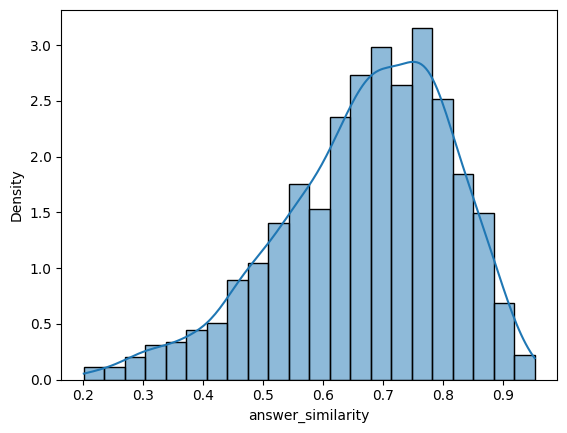

In [95]:
!pip install -q seaborn

import seaborn as sns

sns.histplot(df_rag_responses.answer_similarity, kde=True, stat='density')

## LLM as Judge

Here, we'll use an LLM to validate the outputs of the RAG system. For each question, we ask the LLM to compare the generated and the original answer, and state whether the generated answer is revelant or not, giving reasons.

We'll use the following prompt:

In [97]:
prompt_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as `NON_RELEVANT`, `PARTLY_RELEVANT`, or `RELEVANT`.

Here is the data for evaluation:

# Original Answer
{original_answer_text}

# Question
{question}

# Generated Answer
{llm_answer}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

Sample prompt:

In [112]:
df_rag_responses = pd.read_csv('offline_eval_rag_responses.csv')
rag_responses = df_rag_responses[['question', 'llm_answer', 'original_answer_text']].to_dict(orient='records')

print(prompt_template.format(**rag_responses[100]))

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as `NON_RELEVANT`, `PARTLY_RELEVANT`, or `RELEVANT`.

Here is the data for evaluation:

# Original Answer
chapter: Chapter 4: THE BILL OF RIGHTS
part: Part 1: GENERAL PROVISIONS TO THE BILL OF RIGHTS
title: Article 21: Implementation of rights and fundamental freedoms.
clauses: (1)  It is a fundamental duty of the State and every State organ to observe,
respect, protect, promote and fulfil the rights and fundamental freedoms in the Bill
of Rights.
(2)  The State shall take legislative, policy and other measures, including the
setting of standards, to achieve the progressive realisation of the rights guaranteed
under Article 43.
(3)  All State organs and all public officers have the duty to address the

We send this to an LLM for every question. We'll use a different LLM than was used to generate the initial responses. Mistral AI models are listed [here][9]

[9]: https://docs.mistral.ai/getting-started/models/models_overview/

In [113]:
def llm_judge(prompt):
    response = client.chat.completions.create(
        model='mistral-small-latest',
        messages = [
            {'role': 'user', 'content': prompt}
        ]
    )
    return response.choices[0].message.content

Testing the prompt:

In [116]:
prompt = prompt_template.format(**rag_responses[100])
print(llm_judge(prompt))

{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly addresses the question by quoting the relevant clause from the original answer. It accurately states that the State should enact legislation to fulfil its international human rights obligations, matching the content and context of the original answer."
}


Finally, collect the LLM's response for all questions:

In [122]:
import openai
import time

answers = []

In [123]:
for sample in tqdm(rag_responses):
    prompt = prompt_template.format(**sample)
    answer = None
    while not answer:
        try:
            answer = llm_judge(prompt)
        except openai.RateLimitError:
            time.sleep(30)
    answers.append(answer)
    time.sleep(0.2)

100%|███████████████████████████████████████████████████████████████| 1317/1317 [57:30<00:00,  2.62s/it]


Next, decode the llm judge responses from JSON. For simplicity, we'll skip the malformed ones:

In [147]:
judge_evaluations = []
indices = []
for i, ans in enumerate(answers):
    try:
        decoded_ans = json.loads(ans)
        judge_evaluations.append(decoded_ans)
        indices.append(i)
    except json.JSONDecodeError:
        pass


In [148]:
len(answers) - len(judge_evaluations)

125

There were 125 malformed ones ignored with is about 10% so not too much impact expected

We can now load the judge responses into a dataframe for analysis:

In [152]:
df_judge_evaluations = pd.DataFrame(judge_evaluations, index=indices)
df_judge_evaluations.to_csv('judge_evaluations.csv')

In [153]:
df_judge_evaluations

,Relevance,Explanation
0,RELEVANT,"The generated answer accurately captures the main point of the original answer, stating that 'all sovereign power belongs to the people of Kenya,' which directly aligns with Clause (1) of Article 1 in the original text."
1,RELEVANT,"The generated answer accurately captures the key points from the original answer. It outlines the ways the people of Kenya can exercise their sovereign power, including directly, through representatives, and through state organs. The generated answer also correctly references the specific articles of the constitution related to these points."
2,RELEVANT,"The generated answer accurately lists the state organs to which sovereign power is delegated according to the original answer, including Parliament and the legislative assemblies in the county governments, the national executive and the executive structures in the county governments, and the Judiciary and independent tribunals. It also provides additional context regarding the national security organs, which is relevant but not directly answering the question."
3,RELEVANT,"The generated answer correctly identifies the two levels at which the sovereign power of the people is exercised in Kenya, which are the national level and the county level. It also provides relevant constitutional references that support these points, aligning well with the original answer."
4,RELEVANT,"The generated answer accurately captures the essence of the original answer by highlighting the key articles that establish the Constitution as the ultimate authority in Kenya. It provides a comprehensive and relevant explanation of the factors that make the Constitution supreme, closely aligning with the information given in the original answer."
...,...,...
1311,RELEVANT,"The generated answer accurately captures the maximum waiting period of fourteen days following the publication of the referendum result, as specified in the original answer."
1312,RELEVANT,"The generated answer accurately identifies the previous constitution that was in force before the current one, referring to the text from Article 264 as stated in the original answer."
1313,PARTLY_RELEVANT,"The generated answer provides additional details about the effective date of the new constitution, which is related to when the previous constitution ceased to be in effect. However, it does not directly answer the question about the exact date the previous constitution ceased to be in effect, which is mentioned in the original answer. Therefore, it is partly relevant but not fully addressing the specific question."
1314,RELEVANT,"The generated answer accurately reflects the content of the original answer by stating that the previous constitution was repealed on the effective date. It also specifies the article (Article 264) and mentions the current constitution (2010 Constitution), which aligns with the context provided."


We can join the rag response and llm judge response dataframes to see each evaluation with the related question/answers:

In [156]:
df_combined = df_rag_responses.join(df_judge_evaluations, how='right')
df_combined

,Unnamed: 0,question,llm_answer,original_answer_text,Relevance,Explanation
0,0,Who holds all sovereign power in Kenya according to this Constitution?,"Based on the provided context, specifically Article 1 of the Kenya 2010 Constitution, all sovereign power belongs to the people of Kenya. Therefore, the people of Kenya hold all sovereign power according to this Constitution.","chapter: Chapter 1: SOVEREIGNTY OF THE PEOPLE AND SUPREMACY OF THIS CONSTITUTION\npart: \ntitle: Article 1: Sovereignty of the people.\nclauses: (1) All sovereign power belongs to the people of Kenya and shall be exercised\nonly in accordance with this Constitution.\n(2) The people may exercise their sovereign power either directly or through their\ndemocratically elected representatives.\n(3) Sovereign power under this Constitution is delegated to the following State\norgans, which shall perform their functions in accordance with this Constitution—\n(a) Parliament and the legislative assemblies in the county governments;\n(b) the national executive and the executive structures in the county\ngovernments; and\n(c) the Judiciary and independent tribunals.\n(4) The sovereign power of the people is exercised at—\n(a) the national level; and\n(b) the county level.",RELEVANT,"The generated answer accurately captures the main point of the original answer, stating that 'all sovereign power belongs to the people of Kenya,' which directly aligns with Clause (1) of Article 1 in the original text."
1,1,How can the people of Kenya exercise their sovereign power?,"Based on the provided context, the people of Kenya can exercise their sovereign power in the following ways:\n\n1. **Directly**: According to Article 1(2), the people may exercise their sovereign power directly. This could be through:\n - Referendums or plebiscites, as provided for in Article 257.\n - Initiatives and petitions, as outlined in Article 258.\n - Participating in public consultations and hearings, as required by various articles (e.g., Article 33 for public participation in environmental matters).\n\n2. **Through democratically elected representatives**: The people can also exercise their sovereign power through representatives they elect. This includes:\n - Members of Parliament (MPs), who represent the people at the national level (Article 95).\n - Members of County Assemblies (MCAs), who represent the people at the county level (Article 185).\n - The President and Deputy President, who are elected by the people (Article 136).\n\n3. **Through State organ...","chapter: Chapter 1: SOVEREIGNTY OF THE PEOPLE AND SUPREMACY OF THIS CONSTITUTION\npart: \ntitle: Article 1: Sovereignty of the people.\nclauses: (1) All sovereign power belongs to the people of Kenya and shall be exercised\nonly in accordance with this Constitution.\n(2) The people may exercise their sovereign power either directly or through their\ndemocratically elected representatives.\n(3) Sovereign power under this Constitution is delegated to the following State\norgans, which shall perform their functions in accordance with this Constitution—\n(a) Parliament and the legislative assemblies in the county governments;\n(b) the national executive and the executive structures in the county\ngovernments; and\n(c) the Judiciary and independent tribunals.\n(4) The sovereign power of the people is exercised at—\n(a) the national level; and\n(b) the county level.",RELEVANT,"The generated answer accurately captures the key points from the original answer. It outlines the ways the people of Kenya can exercise their sovereign power, including directly, through representatives, and through state organs. The generated answer also correctly references the specific articles of the constitution related to these points."
2,2,To which state organs is sovereign power delegated?,"Based on the provided context, sovereign power is delegated to the following state organs:\n\n1. **Parliament and the legislative assemblies in the county governments** (Articl

We can now do some analysis:

In [158]:
df_combined.Relevance.value_counts()

Relevance
RELEVANT              865
PARTLY_RELEVANT       241
NON_RELEVANT           85
PARTIALLY_RELEVANT      1
Name: count, dtype: int64

One record was incorrectly labelled as `PARTIALLY_RELEVANT` by the LLM. However, the LLM judged most of the rag generated responses relevant, followed by partially relevant.

We can peek into the non-relevant ones:

In [159]:
df_combined[df_combined.Relevance == 'NON_RELEVANT']

,Unnamed: 0,question,llm_answer,original_answer_text,Relevance,Explanation
13,13,What action is prohibited in establishing a government?,"Based on the provided context, the action prohibited in establishing a government is:\n\n- Establishing a political party on a religious, linguistic, racial, ethnic, gender, or regional basis, or engaging in advocacy of hatred on any such basis. (Article 91(2)(a))","chapter: Chapter 1: SOVEREIGNTY OF THE PEOPLE AND SUPREMACY OF THIS CONSTITUTION\npart: \ntitle: Article 3: Defence of this Constitution.\nclauses: (1) Every person has an obligation to respect, uphold and defend this\nConstitution.\n(2) Any attempt to establish a government otherwise than in compliance with\nthis Constitution is unlawful.",NON_RELEVANT,"The generated answer discusses the prohibition on establishing a political party on certain bases and advocating hatred, which is related to Article 91(2)(a). However, the original answer specifies that any attempt to establish a government outside of the compliance with the Constitution is unlawful, as stated in Article 3(2). Therefore, the generated answer does not directly address the action prohibited in establishing a government as per the original answer."
37,37,Are all religions treated equally by the state?,"Based on the provided context, specifically Article 32 of the Kenya 2010 Constitution, all religions are treated equally by the state. The article states that ""Every person has the right, either individually or in community with others, in public or in private, to manifest any religion or belief through worship, practice, teaching or observance, including observance of a day of worship."" This right is guaranteed to everyone, regardless of their religion, indicating equal treatment. Additionally, Article 32(3) prohibits denial of access to any institution, employment, or facility, or the enjoyment of any right, because of a person's belief or religion, further emphasizing this equality.",chapter: Chapter 2: THE REPUBLIC\npart: \ntitle: Article 8: State and religion.\nclauses: There shall be no State religion.,NON_RELEVANT,"The generated answer references Article 32 of the Kenya 2010 Constitution, which is not related to the content of Chapter 2: THE REPUBLIC or Article 8: State and religion from the original answer. The original answer only states 'There shall be no State religion,' which focuses on the lack of a state religion rather than the equal treatment of all religions."
58,58,What constitutional article must this law satisfy?,"Based on the provided context, the law must satisfy Article 165(3)(b) of the Kenya 2010 Constitution. This article states that the High Court shall have jurisdiction to determine the question whether a right or fundamental freedom in the Bill of Rights has been denied, violated, infringed, or threatened. Therefore, any law that this question is asking about must ensure that it does not infringe upon or threaten any rights or fundamental freedoms outlined in the Bill of Rights.","chapter: Chapter 3: CITIZENSHIP\npart: \ntitle: Article 12: Entitlements of citizens.\nclauses: (1) Every citizen is entitled to—\n(a) the rights, privileges and benefits of citizenship, subject to the limits\nprovided or permitted by this Constitution; and\n(b) a Kenyan passport and any document of registration or identification\nissued by the State to citizens.\n(2) A passport or other document referred to in clause (1)(b) may be denied,\nsuspended or confiscated only in accordance with an Act of Parliament that satisfies\nthe criteria referred to in Article 24.",NON_RELEVANT,"The generated answer mentions Article 165(3)(b), which is not relevant to the question asking about the constitutional article that must be satisfied for passport or document denial, suspension, or confiscation. The original answer specifies Article 24, which is the correct and relevant article."
71,71,When does this Article's provisions take effect for applicants?,"Based on the provided

As seen, the LLM judge did manage to catch some issues with the RAG responses.

## Conclusion

We created a RAG flow and evaluated its responses to synthetically generated questions offline using cosine similarity and LLM as judge.

On average, cosine similarity was at 70% and LLM judge labelled most of the responses as relevant, although some legitimate non-relevant responses were identified.

Once a baseline has been established, the RAG flow can be further be experimented on by tweaking aspects such as retrieval mechanisms, prompts or models to identify any possible improvements.

In addition to offline evaluation, online RAG evaluation with users can also be implemented; for example by asking users to rate the live responses they receive from the RAG application.